In [1]:
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
import torch.utils.data as data
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils, models
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
plt.rcParams.update({'axes.grid': False})

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


In [3]:
class PetDataset(data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale (binary mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [4]:
DATA_DIR = "data"
IMAGE_SIZE = 256
BATCH_SIZE = 16

data_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

mask_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Create datasets
full_dataset = PetDataset(
    image_dir=os.path.join(DATA_DIR, "images"),
    mask_dir=os.path.join(DATA_DIR, "annotations"),
    transform=data_transforms
)

# Train-validation-test split
train_size = int(0.7 * len(full_dataset)) 
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = data.random_split(
    full_dataset, 
    [train_size, val_size, test_size]
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

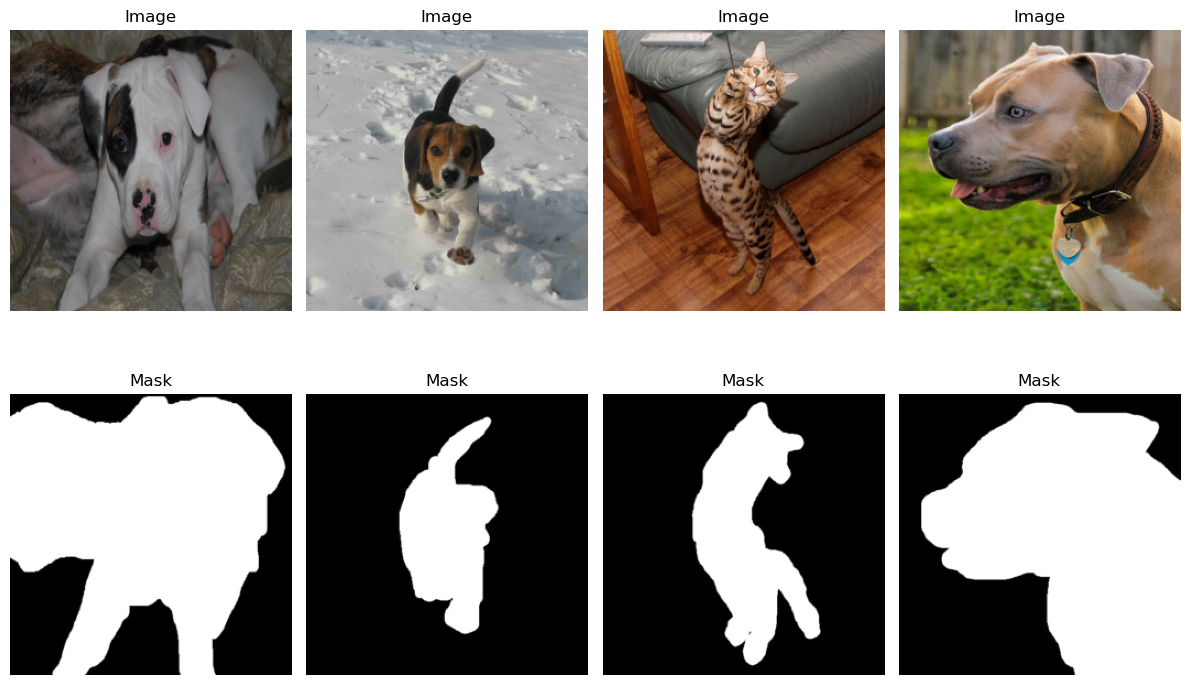

In [5]:
# Get a batch of training data
sample_batch = next(iter(train_loader))
images, masks = sample_batch

# Display a few images and their masks
num_samples = 4
plt.figure(figsize=(12, 8))

for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(masks[i][0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=20, verbose=True):
    train_loss, valid_loss, valid_dice = [], [], []

    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_dice = 0

        # Training
        model.train()
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item() * X.size(0)
        train_loss.append(train_batch_loss / len(trainloader.dataset))

        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in validloader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item() * X.size(0)

                # Calculate Dice score
                dice = dice_score(y_hat, y)
                valid_batch_dice += dice * X.size(0)

        valid_loss.append(valid_batch_loss / len(validloader.dataset))
        valid_dice.append(valid_batch_dice / len(validloader.dataset))

        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.4f} |",
                  f"Valid Loss: {valid_loss[-1]:.4f} |",
                  f"Valid Dice: {valid_dice[-1]:.4f}")

    results = {"train_loss": train_loss, "valid_loss": valid_loss, "valid_dice": valid_dice}
    return results


def dice_score(y_pred, y_true, threshold=0.5):
    """Calculates the Dice coefficient for binary masks."""
    y_pred = (y_pred > threshold).float() # Binarize predictions
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum()
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    return dice.item()


def test(model, criterion, test_loader):
    test_loss = 0
    test_dice = 0

    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            test_loss += loss.item() * X.size(0)

            # Calculate Dice score
            dice = dice_score(y_hat, y)
            test_dice += dice * X.size(0)

    test_loss /= len(test_loader.dataset)
    test_dice /= len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f} | Test Dice: {test_dice:.4f}")

    return {"test_loss": test_loss, "test_dice": test_dice}


In [7]:
class DoubleConv(nn.Module):
    """(Conv2D + BatchNorm + ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [8]:
class PetUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(PetUNet, self).__init__()
        
        # Encoder (Downsampling)
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder (Upsampling)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        
        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder path with skip connections
        dec4 = self.up4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.up3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # Output
        output = self.out_conv(dec1)
        output = torch.sigmoid(output)
        return output

In [9]:
epochs = 20
learning_rate = 1e-4

model = PetUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
results = trainer(model, criterion, optimizer, train_loader, valid_loader, epochs=epochs)

Epoch 1: Train Loss: 0.4066 | Valid Loss: 0.4177 | Valid Dice: 0.8227
Epoch 2: Train Loss: 0.2899 | Valid Loss: 0.2580 | Valid Dice: 0.8732
Epoch 3: Train Loss: 0.2505 | Valid Loss: 0.2610 | Valid Dice: 0.8771
Epoch 4: Train Loss: 0.2264 | Valid Loss: 0.2159 | Valid Dice: 0.8925
Epoch 5: Train Loss: 0.2088 | Valid Loss: 0.2069 | Valid Dice: 0.8976
Epoch 6: Train Loss: 0.1955 | Valid Loss: 0.1996 | Valid Dice: 0.9044
Epoch 7: Train Loss: 0.1833 | Valid Loss: 0.1993 | Valid Dice: 0.9019
Epoch 8: Train Loss: 0.1708 | Valid Loss: 0.1918 | Valid Dice: 0.9083
Epoch 9: Train Loss: 0.1642 | Valid Loss: 0.1749 | Valid Dice: 0.9178
Epoch 10: Train Loss: 0.1521 | Valid Loss: 0.2021 | Valid Dice: 0.9024
Epoch 11: Train Loss: 0.1433 | Valid Loss: 0.1868 | Valid Dice: 0.9114
Epoch 12: Train Loss: 0.1342 | Valid Loss: 0.1772 | Valid Dice: 0.9173
Epoch 13: Train Loss: 0.1246 | Valid Loss: 0.1751 | Valid Dice: 0.9180
Epoch 14: Train Loss: 0.1087 | Valid Loss: 0.2123 | Valid Dice: 0.9032
Epoch 15: Train

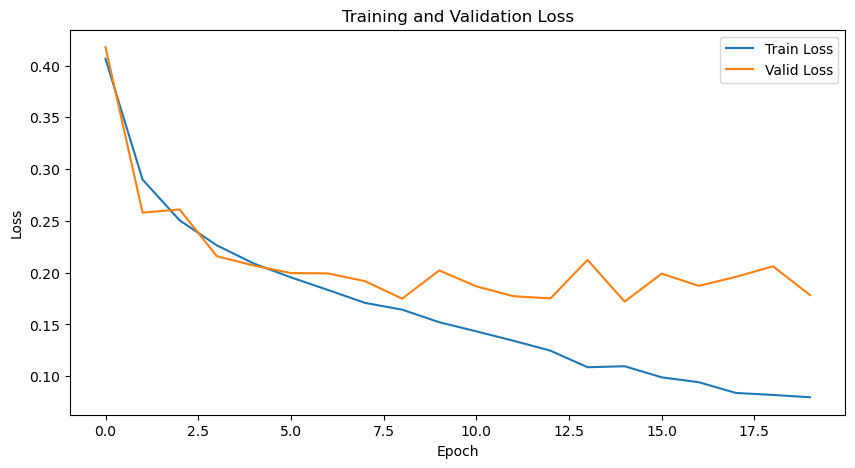

In [11]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(results['train_loss'], label='Train Loss')
plt.plot(results['valid_loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
model.load_state_dict(torch.load("results/models/pet_unet.pth"))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [13]:
test_results = test(model, criterion, test_loader)

Test Loss: 0.1019 | Test Dice: 0.9543


In [18]:
def visualize_predictions(model, test_loader, num_samples=8):
    model.eval()
    samples = 0

    # Calculate the number of rows needed
    rows = num_samples

    # Create a figure with the required number of rows and 4 columns
    fig, axes = plt.subplots(rows, 4, figsize=(16, rows * 4))

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            y_hat = (y_hat > 0.5).float()

            for i in range(X.size(0)):
                if samples >= num_samples:
                    plt.tight_layout()
                    plt.show()
                    return

                # Prepare overlay
                overlay = X[i].cpu().numpy().transpose(1, 2, 0).copy()
                overlay[..., 1] = np.maximum(overlay[..., 1], y[i].cpu().numpy().squeeze())  # Green for GT
                overlay[..., 0] = np.maximum(overlay[..., 0], y_hat[i].cpu().numpy().squeeze())  # Red for Prediction

                # Plot original image
                axes[samples, 0].imshow(X[i].cpu().numpy().transpose(1, 2, 0))
                axes[samples, 0].set_title("Original Image")
                axes[samples, 0].axis("off")

                # Plot ground truth mask
                axes[samples, 1].imshow(y[i].cpu().squeeze(), cmap="gray")
                axes[samples, 1].set_title("Ground Truth")
                axes[samples, 1].axis("off")

                # Plot predicted mask
                axes[samples, 2].imshow(y_hat[i].cpu().squeeze(), cmap="gray")
                axes[samples, 2].set_title("Predicted Mask")
                axes[samples, 2].axis("off")

                # Plot overlay of ground truth and prediction
                axes[samples, 3].imshow(overlay)
                axes[samples, 3].set_title("Overlay (GT: Green, Pred: Red)")
                axes[samples, 3].axis("off")

                samples += 1

    plt.tight_layout()
    plt.show()

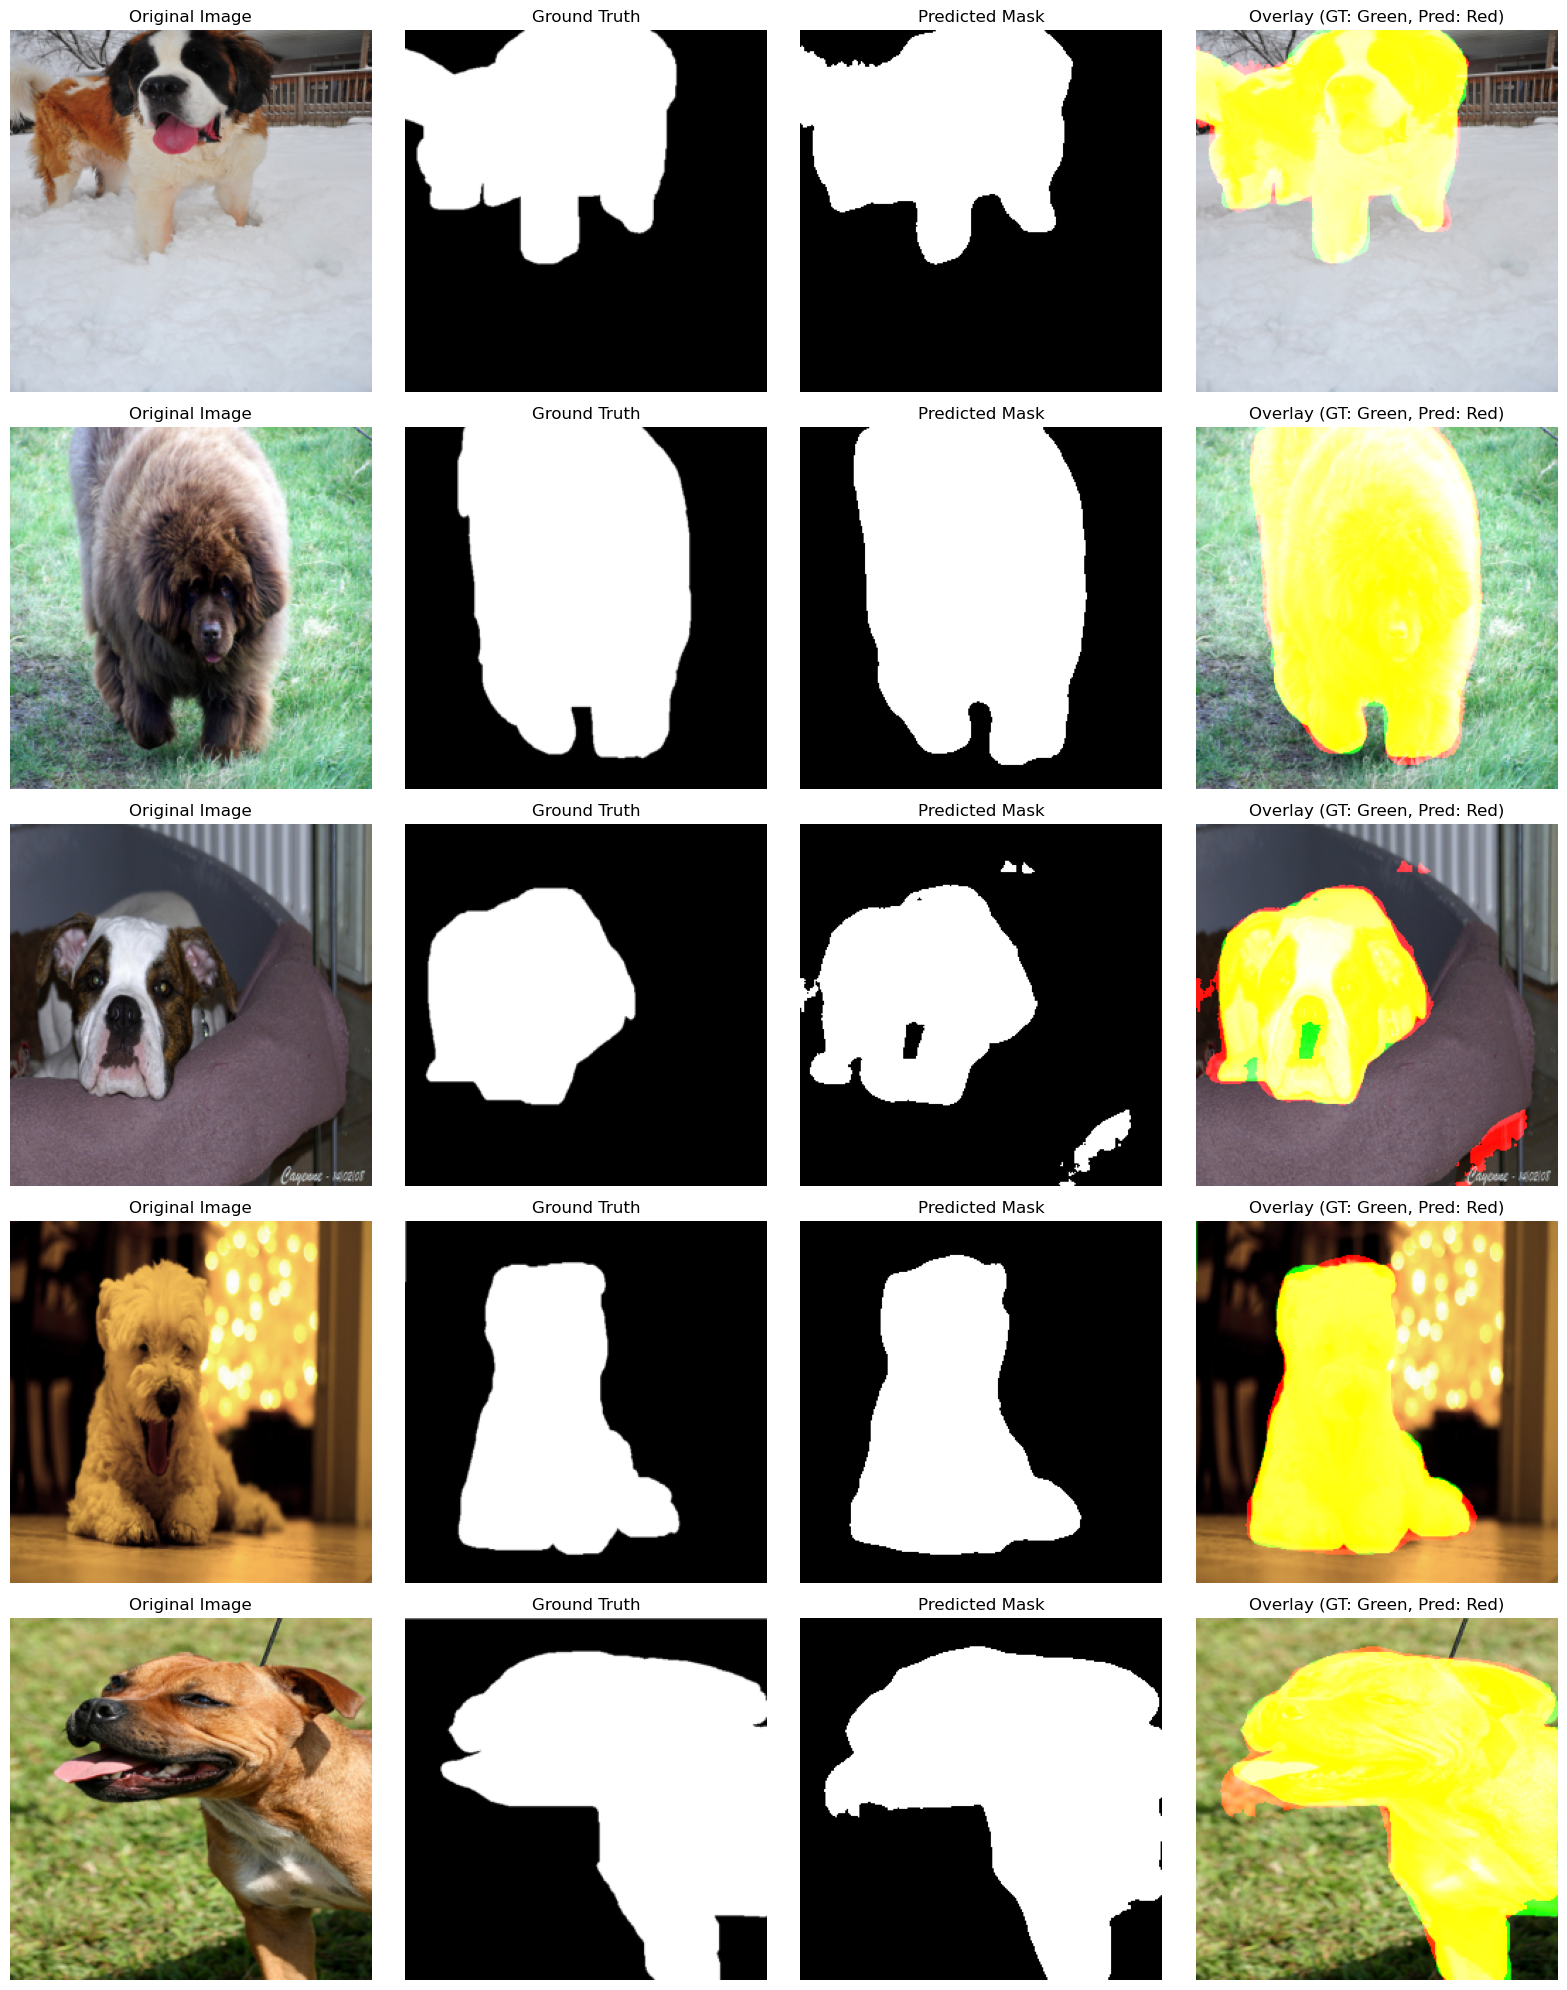

In [19]:
visualize_predictions(model, test_loader, num_samples=5)

In [20]:
torch.save(model.state_dict(), "results/models/pet_unet.pth")
print("Model saved!")

Model saved!
